d:\manoj\Projects\mini project\backend\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0199 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0024 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0017 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0020 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0012 - val_loss: 8.9411e-04 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0013 - val_loss: 9.6830e-04 - learning_rate: 0.0010
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0015
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0015 - val_loss: 8

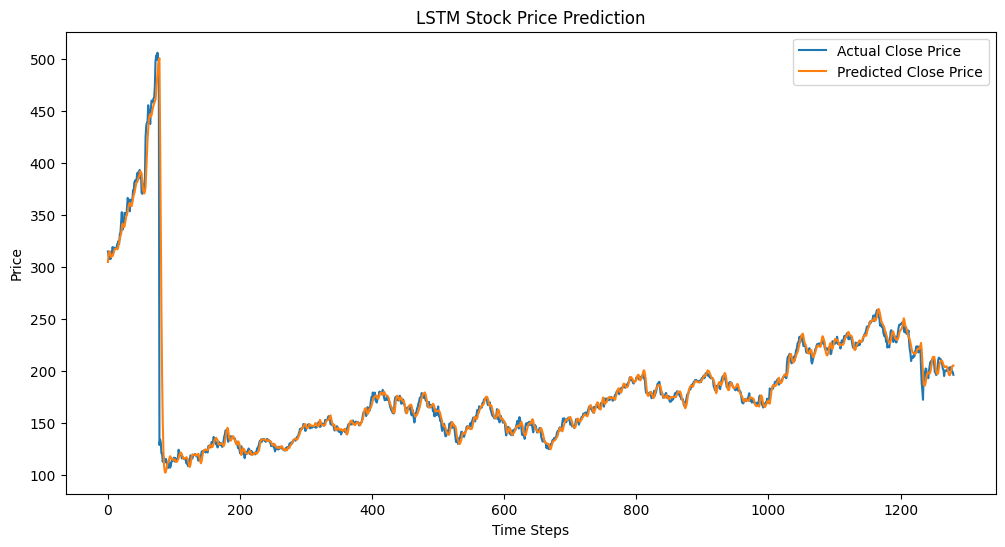

MAE: 4.4281
MSE: 256.6245
RMSE: 16.0195
R^2 Score: 0.9344


In [1]:
# Install package (run once)
# !pip install alpha_vantage ta

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Alpha Vantage API key
API = 'N79LFHXXESUZAA0F'

# Fetch data from Alpha Vantage
ts = TimeSeries(key=API, output_format='pandas')
df, metadata = ts.get_daily(symbol='AAPL', outputsize='full')

# Rename columns for convenience
df = df.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
})

# Sort by date ascending
df = df.sort_index()

# Add technical indicators
def add_technical_indicators(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df = df.dropna()
    return df

df = add_technical_indicators(df)

# Select features
features = ['Close', 'SMA_20', 'RSI']
data = df[features]

# Scale features between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare sequences for LSTM
seq_len = 20
X, y = [], []

for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i, 0])  # Predict 'Close' price

X, y = np.array(X), np.array(y)

# Split into train and test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_len, len(features))))
model.add(Dropout(0.3))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)

# Predict on test data
y_pred = model.predict(X_test)

# Inverse scale predictions and true values (only Close price)
inv_pred = np.zeros((len(y_pred), len(features)))
inv_pred[:, 0] = y_pred[:, 0]

inv_true = np.zeros((len(y_test), len(features)))
inv_true[:, 0] = y_test

y_pred_unscaled = scaler.inverse_transform(inv_pred)[:, 0]
y_test_unscaled = scaler.inverse_transform(inv_true)[:, 0]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual Close Price')
plt.plot(y_pred_unscaled, label='Predicted Close Price')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

# Optional: Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")


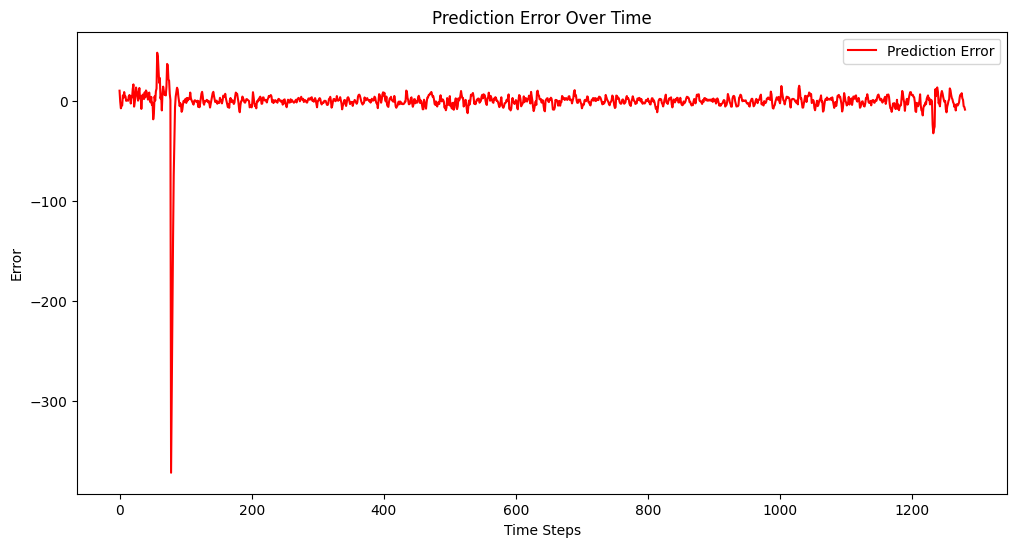

In [2]:
y_error = y_test_unscaled - y_pred_unscaled
plt.figure(figsize=(12, 6))
plt.plot(y_error, label='Prediction Error', color='red')
plt.title('Prediction Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.legend()
plt.show()


In [3]:
# Get the last seq_len days of scaled data to predict next day
last_sequence = scaled_data[-seq_len:]  # shape (seq_len, features)

# Reshape to (1, seq_len, features) for prediction
last_sequence = last_sequence.reshape((1, seq_len, len(features)))

# Predict next day's scaled close price
next_day_pred_scaled = model.predict(last_sequence)

# Prepare array for inverse transform (fill zeros for other features)
next_day_pred_full = np.zeros((1, len(features)))
next_day_pred_full[0, 0] = next_day_pred_scaled[0, 0]

# Inverse transform to original scale
next_day_pred_price = scaler.inverse_transform(next_day_pred_full)[0, 0]

print(f"Predicted next day's Close price: {next_day_pred_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted next day's Close price: 204.65


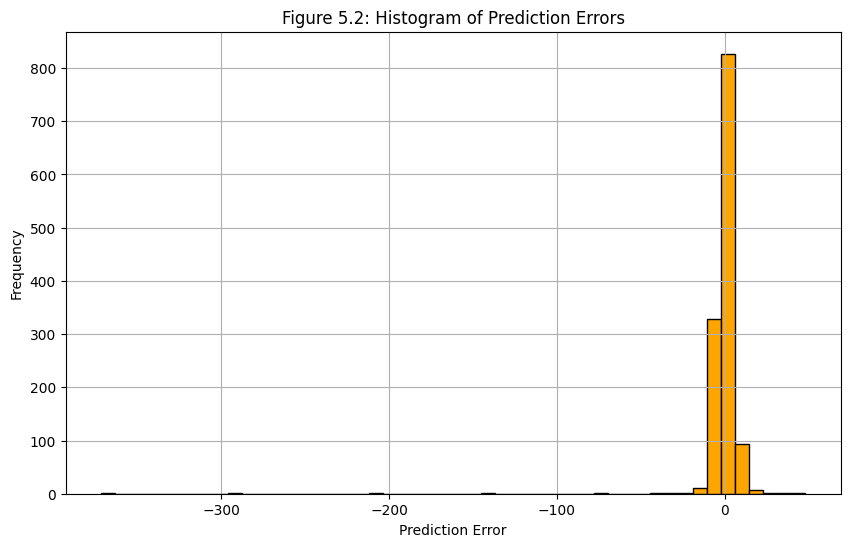

In [4]:
# Figure 5.2: Histogram of Prediction Errors
plt.figure(figsize=(10, 6))
plt.hist(y_error, bins=50, color='orange', edgecolor='black')
plt.title('Figure 5.2: Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


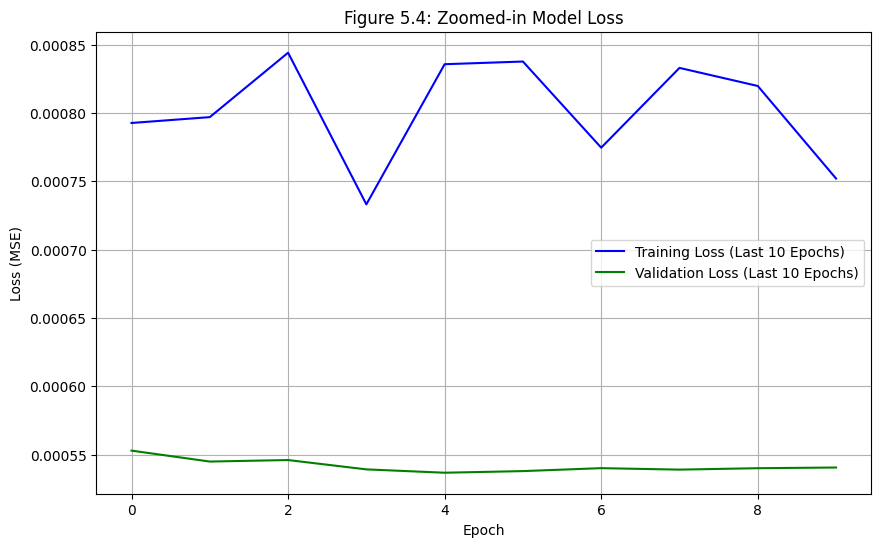

In [5]:
# Figure 5.4: Zoomed-in Loss Plot (Last 10 Epochs)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'][-10:], label='Training Loss (Last 10 Epochs)', color='blue')
plt.plot(history.history['val_loss'][-10:], label='Validation Loss (Last 10 Epochs)', color='green')
plt.title('Figure 5.4: Zoomed-in Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


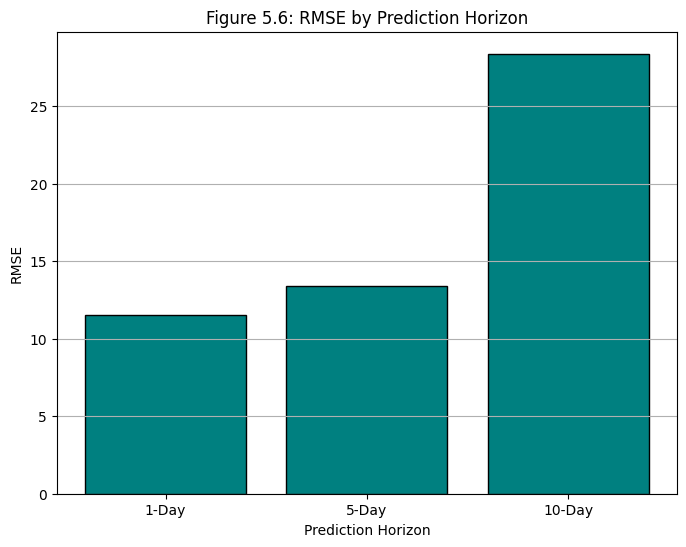

In [6]:
from sklearn.metrics import mean_squared_error

horizons = [1, 5, 10]
rmse_by_horizon = []

for h in horizons:
    y_pred_shifted = np.roll(y_pred_unscaled, -h)
    y_true_shifted = y_test_unscaled
    mask = np.arange(len(y_pred_unscaled) - h)
    rmse_h = np.sqrt(mean_squared_error(y_true_shifted[mask], y_pred_shifted[mask]))
    rmse_by_horizon.append(rmse_h)

# Figure 5.6: Bar Chart for RMSE by Horizon
plt.figure(figsize=(8, 6))
plt.bar(['1-Day', '5-Day', '10-Day'], rmse_by_horizon, color='teal', edgecolor='black')
plt.title('Figure 5.6: RMSE by Prediction Horizon')
plt.xlabel('Prediction Horizon')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()
